# BASIC CONFIGURATIONS

In [1]:
# Setup the library
import pyrogue as pr
import os, sys
import matplotlib.pyplot as plt
import time
import numpy as np
import math
from scipy.optimize import curve_fit
import pprint
import inspect 

top_level=f'{os.getcwd()}/../'
rootTopLevel = top_level+'script/'
pr.addLibraryPath( rootTopLevel )

import setupLibPaths

import ePix320kM as devBoard

args = None


In [2]:
# ONLY RUN ONCE!
# Defining root
# If crashes, make sure the deve is correct.
root =  devBoard.Root(   
        top_level  = rootTopLevel,
        dev        = '/dev/datadev_1',
        pollEn     = False,
        initRead   = True,
        serverPort = 9099,
        pciePgpEn  = False,
        justCtrl   = False,
        DDebugSize = 4000)
root.start()

# example showing a read
AxiVersion = root.Core.AxiVersion
print ( '###################################################')
print ( '#             Firmware Version                    #')
print ( '###################################################')
AxiVersion.printStatus()
print ( '###################################################')

{'name': 'ScopeData0'}
{'name': 'ScopeData1'}
{'name': 'ScopeData2'}
{'name': 'ScopeData3'}
Root.Core.Si5345Pll.Page0.DataBlock.setPollInterval(1)
Start: Started zmqServer on ports 9099-9101
    To start a gui: python -m pyrogue gui --server='localhost:9099'
    To use a virtual client: client = pyrogue.interfaces.VirtualClient(addr='localhost', port=9099)
Root.Core.AxiVersion count reset called
###################################################
#             Firmware Version                    #
###################################################
Path         = Root.Core.AxiVersion
FwVersion    = 0x1000300
UpTime       = 5 days, 23:01:00
GitHash      = 0x9550c2a95f7e334393e52bfde914e26fb20f11b8
XilinxDnaId  = 0x400200000139d7204c81a145
FwTarget     = ePixHRM320k
BuildEnv     = Vivado v2023.1
BuildServer  = rdsrv314 (Ubuntu 20.04.6 LTS)
BuildDate    = Wed 17 Jan 2024 11:42:17 PM PST
Builder      = dnajjar
###################################################


In [3]:
# Useful short names
APP  = root.App
AXIV = root.Core.AxiVersion
ASICTOP = APP.AsicTop
TRIG = ASICTOP.TriggerRegisters
ASIC0 = APP.Mv2Asic[0]
ASIC1 = APP.Mv2Asic[1]
ASIC2 = APP.Mv2Asic[2]
ASIC3 = APP.Mv2Asic[3]
HSDAC = APP.Dac.FastDac 
PKREG0 = ASICTOP.DigAsicStrmRegisters0
PKREG1 = ASICTOP.DigAsicStrmRegisters1
PKREG2 = ASICTOP.DigAsicStrmRegisters2
PKREG3 = ASICTOP.DigAsicStrmRegisters3
BATCHER0 = ASICTOP.BatcherEventBuilder0
BATCHER1 = ASICTOP.BatcherEventBuilder1
BATCHER2 = ASICTOP.BatcherEventBuilder2
BATCHER3 = ASICTOP.BatcherEventBuilder3
DEBUG0 = root._dbg[0]
DEBUG1 = root._dbg[1]
DEBUG2 = root._dbg[2]
DEBUG3 = root._dbg[3]
DATARCV0 = root.DataReceiver0
DATARCV1 = root.DataReceiver1
DATARCV2 = root.DataReceiver2
DATARCV3 = root.DataReceiver3
FULLRATERCV0 = root.fullRateDataReceiver[0]
FULLRATERCV1 = root.fullRateDataReceiver[1]
FULLRATERCV2 = root.fullRateDataReceiver[2]
FULLRATERCV3 = root.fullRateDataReceiver[3]
DAC = APP.Dac
REGCTRL = ASICTOP.RegisterControlDualClock

In [4]:
# Configure clock to 168 MHz and configures all ASICS
root.InitASIC([4,1,1,1,1])

Rysync ASIC started
Init ASIC script started
Loading PLL configuration
Loading supply configuration
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_PowerSupply_Enable.yml
Loading lane delay configurations
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_SspMonGrp_carrier3.yml
Loading waveforms configuration
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_RegisterControl.yml
Loading packet register configurations
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_PacketRegisters.yml
Loading batcher configurations
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_BatcherEventBuilder.yml
Taking asic off of reset
Loading ASICs and timing configuration
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_ASIC_u1_PLLBypass.yml
Loading /u1/lorenzor/epix-hr-m-320k/software/noteboo

In [5]:
root.disableAndCleanAllFullRateDataRcv()
root.enableDataRcv(False)
root.enableDataDebug(False)

#run some triggers and exercise lanes and locks
frames = 100
rate = 5000

root.hwTrigger(frames, rate)

Stop Triggers command executed
Set Auto Trigger command executed
Start Auto Trigger command executed
Triggers sent: 100
Stop Triggers command executed


In [6]:
#get locked lanes
time.sleep(3)
root.getLaneLocks()

#Disabled lanes in ASICS
for asicIndex in range(4) : 
    root.App.AsicTop.DigAsicStrmRegisters0.enable.set(True)
    print("ASIC{}: {:#x}".format(asicIndex, getattr(root.App.AsicTop, f"DigAsicStrmRegisters{asicIndex}").DisableLane.get()))

ASIC0: 0xffffff
ASIC1: 0xfffffa
ASIC2: 0xb6ffff
ASIC3: 0xfeffff
ASIC0: 0x20000
ASIC1: 0x10045
ASIC2: 0x490000
ASIC3: 0x540140


In [7]:
#Enable data receivers and run some triggers
root.enableDataRcv(True)
root.enableAllAsics(True)
for i in range (5):
    root.Trigger()
    
root.enableDataRcv(False)
root.enableAllAsics(False)

# Begin custom testing

Select which ASIC we want to look at... 0 to 4

In [8]:
%run supportFunctions.ipynb
%run dataProcFunctions.ipynb

In [9]:
ASIC = ASIC1
ASICNUM = 1
DATADEBUG= DEBUG1

root.enableAsic(ASICNUM, True)

In [17]:
# Set best settings - pipoclk delay
setBestSettings(REGCTRL,ASIC0, ASIC1, ASIC2, ASIC3)

R0 Width set to 7.808uS
R0 Delay set to 1.280uS
Acq1 Width set to 3.584uS
Acq1 Delay set to 4.864uS
-------------------------
Baseline time:    3.5839999999999996 uS
Integration time: 3.584 uS
Sampling done at: 8.448 uS
-------------------------
ASIC configured


In [11]:
PKREG1.CountReset()
for i in range(24):
    print("PKREG1.TimeoutCntLane[{}]={}".format(i, PKREG1.TimeoutCntLane[i].get()))
imgDesc = run_asic_test(DATADEBUG, numFrames = 2048, initialDelay = 0)


PKREG1.TimeoutCntLane[0]=0
PKREG1.TimeoutCntLane[1]=0
PKREG1.TimeoutCntLane[2]=0
PKREG1.TimeoutCntLane[3]=0
PKREG1.TimeoutCntLane[4]=0
PKREG1.TimeoutCntLane[5]=0
PKREG1.TimeoutCntLane[6]=0
PKREG1.TimeoutCntLane[7]=0
PKREG1.TimeoutCntLane[8]=0
PKREG1.TimeoutCntLane[9]=0
PKREG1.TimeoutCntLane[10]=0
PKREG1.TimeoutCntLane[11]=0
PKREG1.TimeoutCntLane[12]=0
PKREG1.TimeoutCntLane[13]=0
PKREG1.TimeoutCntLane[14]=0
PKREG1.TimeoutCntLane[15]=0
PKREG1.TimeoutCntLane[16]=0
PKREG1.TimeoutCntLane[17]=0
PKREG1.TimeoutCntLane[18]=0
PKREG1.TimeoutCntLane[19]=0
PKREG1.TimeoutCntLane[20]=0
PKREG1.TimeoutCntLane[21]=0
PKREG1.TimeoutCntLane[22]=0
PKREG1.TimeoutCntLane[23]=0
Stop Triggers command executed
Stop Triggers command executed


KeyboardInterrupt: 

In [12]:
TimeoutCntLane = [0] * 24
disable = PKREG1.DisableLane.get()
for i in range(24):
    print("PKREG1.TimeoutCntLane[{}]={}".format(i, PKREG1.TimeoutCntLane[i].get()))
    TimeoutCntLane[i] = PKREG1.TimeoutCntLane[i].get()
    if(TimeoutCntLane[i]> 20) :
        #disable lane
        disable = disable | 0x1<<i

PKREG1.DisableLane.set(disable)

#get locked lanes
root.getLaneLocks()

#Disabled lanes in ASICS
for asicIndex in range(4) : 
    root.App.AsicTop.DigAsicStrmRegisters0.enable.set(True)
    print("ASIC{}: {:#x}".format(asicIndex, getattr(root.App.AsicTop, f"DigAsicStrmRegisters{asicIndex}").DisableLane.get()))

PKREG1.TimeoutCntLane[0]=2048
PKREG1.TimeoutCntLane[1]=1
PKREG1.TimeoutCntLane[2]=0
PKREG1.TimeoutCntLane[3]=1
PKREG1.TimeoutCntLane[4]=1
PKREG1.TimeoutCntLane[5]=1
PKREG1.TimeoutCntLane[6]=1
PKREG1.TimeoutCntLane[7]=1
PKREG1.TimeoutCntLane[8]=1
PKREG1.TimeoutCntLane[9]=1
PKREG1.TimeoutCntLane[10]=1
PKREG1.TimeoutCntLane[11]=1
PKREG1.TimeoutCntLane[12]=1
PKREG1.TimeoutCntLane[13]=1
PKREG1.TimeoutCntLane[14]=1
PKREG1.TimeoutCntLane[15]=1
PKREG1.TimeoutCntLane[16]=1
PKREG1.TimeoutCntLane[17]=1
PKREG1.TimeoutCntLane[18]=1
PKREG1.TimeoutCntLane[19]=1
PKREG1.TimeoutCntLane[20]=1
PKREG1.TimeoutCntLane[21]=2048
PKREG1.TimeoutCntLane[22]=1
PKREG1.TimeoutCntLane[23]=1
ASIC0: 0xffffff
ASIC1: 0xfffffa
ASIC2: 0xb6ffff
ASIC3: 0xffffff
ASIC0: 0x20000
ASIC1: 0x210045
ASIC2: 0x490000
ASIC3: 0x540140


In [13]:
imgDesc = run_asic_test(DATADEBUG, numFrames = 2048, initialDelay = 0)


Stop Triggers command executed
DataDebug[1]: descramble error
rawData length 12336
Stop Triggers command executed
Data Descrambled
(192, 384, 2049)
Delta Aquisition Counter: 2048
Number of frames received: (192, 384, 2049)


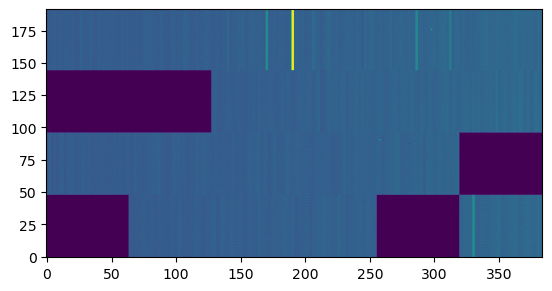

In [23]:
plt.imshow(imgDesc[:,:,-1], origin='lower')

# Fixed High gain = set CompTH to minimum

In [28]:
# Set threshold to the minimum voltage (maximum energy, should not switch)
ASIC3.CompTH_ePixM.set(0)
# ASIC3.Precharge_DAC_ePixM.set(40)

# Reference pixel
ref_row = 100
ref_col = 150

# Get ramps and calculate gain
ChInjValues, PixOutValues = chargeInjRamp(DATADEBUG, AsicNum=ASICNUM, Min=100, Max=1023, numSteps=100)

Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Des

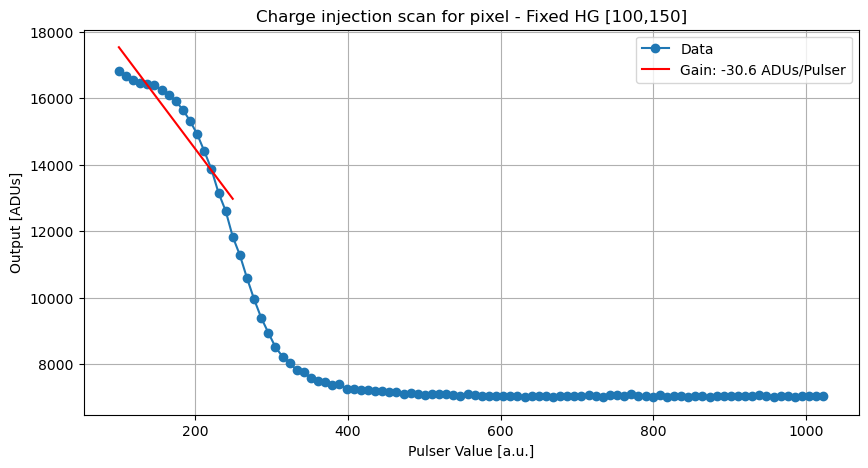

In [29]:
# Reference pixel
ref_row = 100
ref_col = 150

plt.figure(figsize = (10,5))
plt.plot(ChInjValues, PixOutValues,'o-', label='Data')

plt.xlabel("Pulser Value [a.u.]")
plt.ylabel("Output [ADUs]")

# Fit
fit_indices = (ChInjValues <= 250)
ChInjValues_fit = ChInjValues[fit_indices]
PixOutValues_fit = PixOutValues[fit_indices]

# Perform the linear fit using polyfit
gain, offset = np.polyfit(ChInjValues_fit, PixOutValues_fit, 1)
polyfit_function = np.poly1d([gain, offset])
plt.plot(ChInjValues_fit, polyfit_function(ChInjValues_fit), color='red', label='Gain: {:.1f} ADUs/Pulser'.format(gain))

plt.title('Charge injection scan for pixel - Fixed HG [{},{}]'.format(ref_row,ref_col))
plt.legend()
plt.grid(True)

# Fixed low-gain: set CompTH to maximum (min energy)

In [30]:
# Set threshold to the minimum voltage (maximum energy, should not switch)
ASIC3.CompTH_ePixM.set(63)
ASIC3.Precharge_DAC_ePixM.set(50)
ASIC3.mTest.set(False)

# Reference pixel
ref_row = 100
ref_col = 150

# Optimal bias settings
ASIC3.RefinN.set(4)
ASIC3.RefinP.set(4)


# Get ramps and calculate gain
ChInjValues, PixOutValues = chargeInjRamp(DATADEBUG, AsicNum=ASICNUM, Min=100, Max=1023, numSteps=100)

Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Des

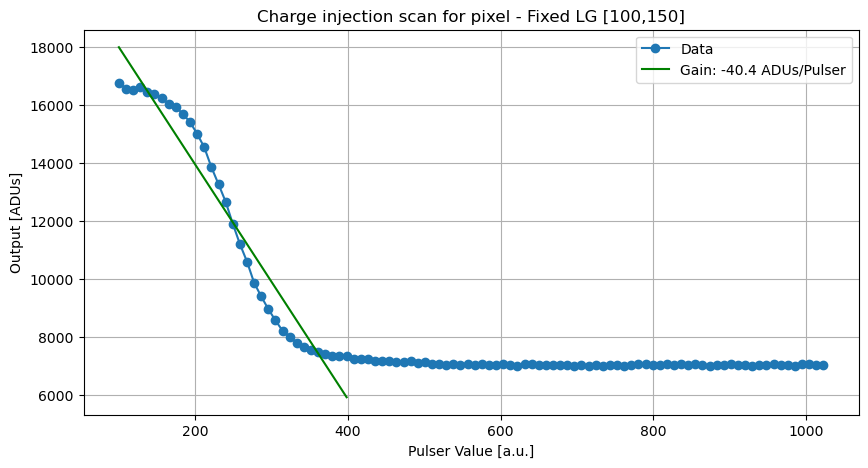

In [31]:
PixOutValues = clearB16(PixOutValues.astype(int))

plt.figure(figsize = (10,5))
plt.plot(ChInjValues, PixOutValues,'o-', label='Data')

plt.xlabel("Pulser Value [a.u.]")
plt.ylabel("Output [ADUs]")


# Fit
fit_indices = (ChInjValues <= 400)
ChInjValues_fit = ChInjValues[fit_indices]
PixOutValues_fit = PixOutValues[fit_indices]

# Perform the linear fit using polyfit
gain, offset = np.polyfit(ChInjValues_fit, PixOutValues_fit, 1)
polyfit_function = np.poly1d([gain, offset])
plt.plot(ChInjValues_fit, polyfit_function(ChInjValues_fit), color='green', label='Gain: {:.1f} ADUs/Pulser'.format(gain))

plt.title('Charge injection scan for pixel - Fixed LG [{},{}]'.format(ref_row,ref_col))
plt.legend()
plt.grid(True)

# Auto-gain switching: tune CompTH and Vprech

In [32]:
# Set threshold to the minimum voltage (maximum energy, should not switch)
ASIC3.CompTH_ePixM.set(10)
ASIC3.Precharge_DAC_ePixM.set(40)

# Reference pixel
ref_row = 100
ref_col = 150

ChInjValues, PixOutValues = ChInjRamp(numberOfTriggers=3,Min=100,Max=1023,numSteps=40)

TypeError: ChInjRamp() missing 1 required positional argument: 'dataDebug'

In [ ]:
PixOutValues = clearB16(PixOutValues.astype(int))

plt.figure(figsize = (10,5))
plt.plot(ChInjValues, PixOutValues,'o-', label='Data')

plt.xlabel("Pulser Value [a.u.]")
plt.ylabel("Output [ADUs]")


# Fit HG
fit_indices = (ChInjValues <= 250)
ChInjValues_fit = ChInjValues[fit_indices]
PixOutValues_fit = PixOutValues[fit_indices]

# Perform the linear fit using polyfit
gain, offset = np.polyfit(ChInjValues_fit, PixOutValues_fit, 1)
polyfit_function = np.poly1d([gain, offset])
plt.plot(ChInjValues_fit, polyfit_function(ChInjValues_fit), color='green', label='Gain HG: {:.1f} ADUs/Pulser'.format(gain))
gain_hg = gain

# Fit LG
fit_indices = (ChInjValues <= 800) & (ChInjValues > 300)
ChInjValues_fit = ChInjValues[fit_indices]
PixOutValues_fit = PixOutValues[fit_indices]

# Perform the linear fit using polyfit
gain, offset = np.polyfit(ChInjValues_fit, PixOutValues_fit, 1)
polyfit_function = np.poly1d([gain, offset])
plt.plot(ChInjValues_fit, polyfit_function(ChInjValues_fit), color='green', label='Gain HG: {:.1f} ADUs/Pulser'.format(gain))
gain_lg = gain


plt.title('Charge injection scan for pixel - Auto-gain, ratio HG/LG = {}]'.format(gain_hg/gain_lg))
plt.legend()
plt.grid(True)